In [9]:
import numpy as np
import matplotlib.pyplot as plt



from functions.parse_data import synth_dataloader
import functions.handy_functions as hf
import torch

from cot_train.utils import StatCollector, MLP5, mlp_inference

from pysolar.solar import *

from scipy.stats import pearsonr

from multivariate_quantile_regression.network_model import QuantileNetwork

In [2]:
#Load in images with information
import xarray as xr
f='/cloud/openeo/tiny_forest_5'
loaded_data = xr.open_dataset(f, engine='netcdf4', decode_times=True)
nodata = loaded_data.attrs.get("nodata", None)
loaded_data = loaded_data.where(loaded_data != nodata, np.nan)
times=loaded_data['t']
variables=loaded_data.variables
loaded_data

<xarray.Dataset> Size: 20MB
Dimensions:      (t: 7, y: 170, x: 178, sun_zenith: 7)
Coordinates:
  * t            (t) datetime64[ns] 56B 2020-06-13T10:30:31.024000 ... 2020-0...
  * y            (y) float64 1kB 6.51e+06 6.51e+06 ... 6.508e+06 6.508e+06
  * x            (x) float64 1kB 4.782e+05 4.782e+05 ... 4.8e+05 4.8e+05
    spatial_ref  int32 4B 3006
  * sun_zenith   (sun_zenith) float64 56B 35.3 31.92 34.05 ... 34.83 31.44 33.54
Data variables: (12/16)
    b02          (t, y, x) float64 2MB 795.0 791.0 802.0 ... 1.223e+03 1.218e+03
    b03          (t, y, x) float64 2MB 606.0 612.0 636.0 ... 1.036e+03 1.058e+03
    b04          (t, y, x) float64 2MB 376.0 365.0 377.0 ... 791.0 798.0 849.0
    b05          (t, y, x) float64 2MB 619.0 588.0 588.0 ... 1.007e+03 1.028e+03
    b06          (t, y, x) float64 2MB 1.336e+03 1.304e+03 ... 1.843e+03
    b07          (t, y, x) float64 2MB 1.525e+03 1.548e+03 ... 2.169e+03
    ...           ...
    b11          (t, y, x) float64 2MB 728.0 700.0 700.0 ... 1.183e+03 1.184e+03
    b12          (t, y, x) float64 2MB 323.0 319.0 319.0 ... 646.0 646.0 653.0
    west         float64 8B 14.62
    east         float64 8B 14.65
    north        float64 8B 58.73
    south        float64 8B 58.71
Attributes:
    crs:                EPSG:3006
    nodata:             -9999
    collection:         s2_msi_l1c
    datetime_from_dim:  2024-03-27T12:10:53.308569

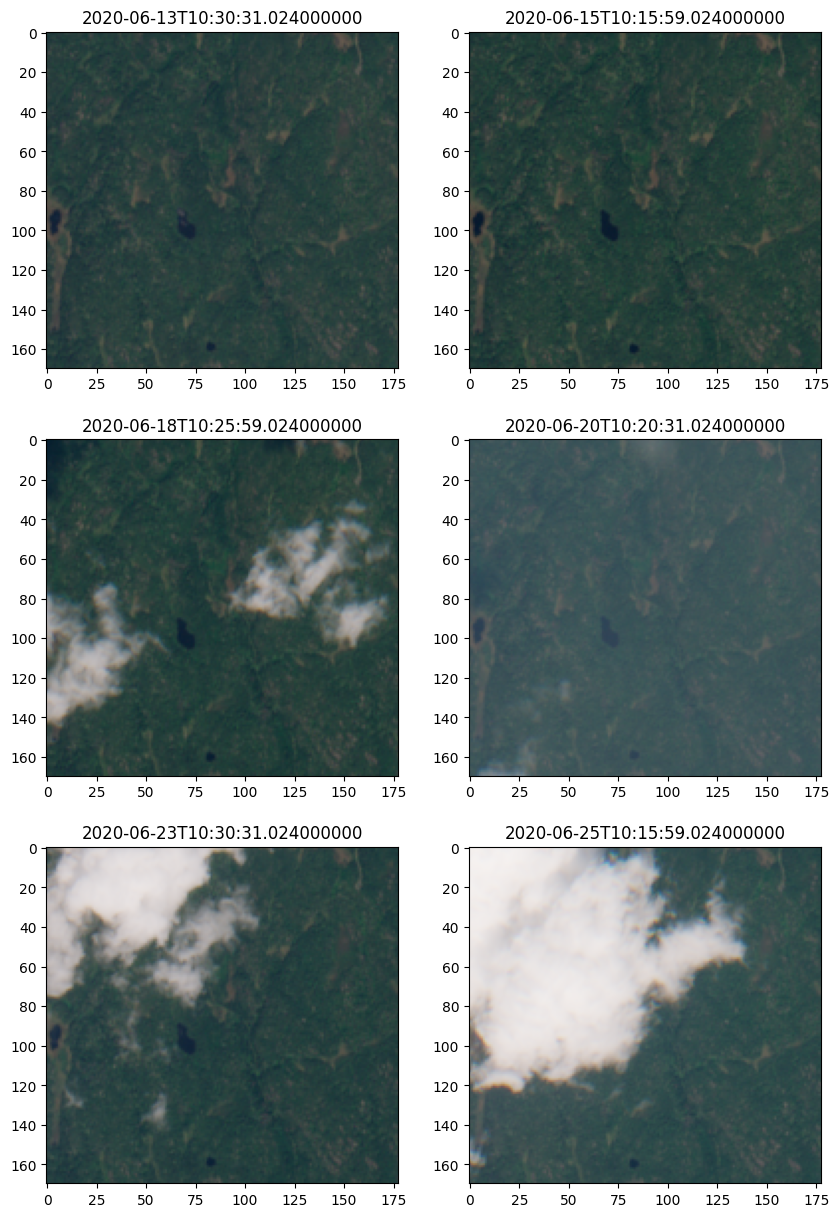

In [3]:
ncols=2
nrows=int(np.ceil((len(times)-1)/ncols))
divide=10000
ims=[]
ims_show=[]
sun_zenith_angles=loaded_data.sun_zenith.data

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):

    ## Get bands ##
    b02=variables['b02'].data[i,:,:]/divide
    b03=variables['b03'].data[i,:,:]/divide
    b04=variables['b04'].data[i,:,:]/divide
    b05=variables['b05'].data[i,:,:]/divide
    b06=variables['b06'].data[i,:,:]/divide
    b07=variables['b07'].data[i,:,:]/divide
    b08=variables['b08'].data[i,:,:]/divide
    b8a=variables['b8a'].data[i,:,:]/divide
    b09=variables['b09'].data[i,:,:]/divide
    b10=variables['b10'].data[i,:,:]/divide
    b11=variables['b11'].data[i,:,:]/divide
    b12=variables['b12'].data[i,:,:]/divide

    ## Save image ##
    im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],12))
    im[:,:,0]=b02
    im[:,:,1]=b03
    im[:,:,2]=b04
    im[:,:,3]=b05
    im[:,:,4]=b06
    im[:,:,5]=b07
    im[:,:,6]=b08
    im[:,:,7]=b8a
    im[:,:,8]=b09
    im[:,:,9]=b10
    im[:,:,10]=b11
    im[:,:,11]=b12
    ims.append(im)

    im_show=hf.Sentinel2TrueColor(im)
    ims_show.append(im_show)

    ax.imshow(im_show)
    ax.set_title(times.data[i])
    

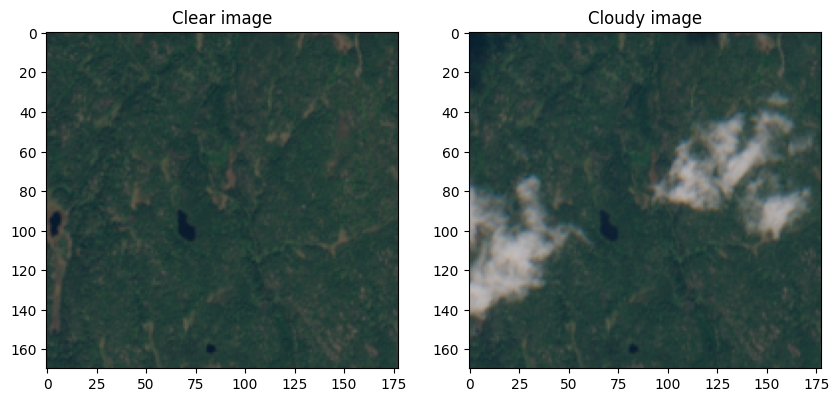

In [5]:
#Choose clear/cloudy pair:
pair=[1,2]
im_clear=ims[pair[0]]
im_cloud=ims[pair[1]]

#Plot chosen images
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0].imshow(ims_show[pair[0]])
axs[0].title.set_text('Clear image')
axs[1].imshow(ims_show[pair[1]])
axs[1].title.set_text('Cloudy image')

In [6]:
# Reshape cloudy data for algorithm input
im_shape=np.shape(im_cloud)
im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]+1)) #+1 for sun zenith angle
for i in range(im_shape[2]):
    im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

im_cloud_r[:,-1]=sun_zenith_angles[pair[1]]

Test algorithms with and without COT:

NMSE before correction, Band 2: 1.0138240622272392
NMSE after correction, Band 2: 0.24196244272847928
 
NMSE before correction, Band 3: 1.9203154913745937
NMSE after correction, Band 3: 0.7017025312960624
 
NMSE before correction, Band 4: 15.179071437111068
NMSE after correction, Band 4: 7.2116793506069445
 
NMSE before correction, Band 5: 1.8003494565258744
NMSE after correction, Band 5: 0.8670209986669923
 
NMSE before correction, Band 6: 0.06905843466868061
NMSE after correction, Band 6: 0.03631563093462487
 
NMSE before correction, Band 7: 0.041539275948653746
NMSE after correction, Band 7: 0.02340682695573407
 
NMSE before correction, Band 8: 0.03249465771967791
NMSE after correction, Band 8: 0.01790646548155548
 
NMSE before correction, Band 8A: 0.028626602621410195
NMSE after correction, Band 8A: 0.019091919666309777
 
NMSE before correction, Band 9: 0.020094394686398943
NMSE after correction, Band 9: 0.015513060637853432
 
NMSE before correction, Band 10: 0.009193989323459727
N

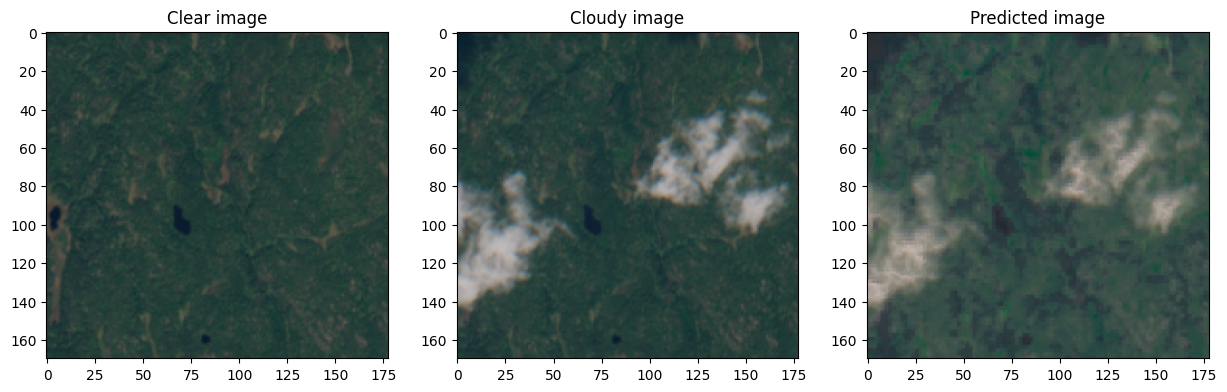

In [8]:
#Without COT:
input=im_cloud_r

## Load models
main_filepath='pytorch_models/COT_est_inp_noCOT'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(input)
    else:   
        pred=pred+model.predict(input)
pred=pred/len(models)

##Reshape back
index_median=1
im_pred=np.zeros(im_shape)
im_unc=np.zeros(im_shape)
im_lower=np.zeros(im_shape)
im_higher=np.zeros(im_shape)
for i in range(im_shape[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape[0:2])
    im_lower[:,:,i]=np.reshape(pred[:,i,0],im_shape[0:2])
    im_higher[:,:,i]=np.reshape(pred[:,i,-1],im_shape[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape[0:2])

#Create color corrected prediction
im_pred_show=hf.Sentinel2TrueColor(im_pred)

#Plot clear/cloudy/pred
plt.rcParams['figure.figsize'] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(ims_show[pair[0]])
axs[1].imshow(ims_show[pair[1]])
axs[2].imshow(im_pred_show)
axs[0].title.set_text('Clear image')
axs[1].title.set_text('Cloudy image')
axs[2].title.set_text('Predicted image')

#Find NMSE of all bands, compare cloudy/clear vs pred/clear
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square(im_clear-im_cloud),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square(im_clear-im_pred),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im_clear),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(NMSE_pred)))

bands=np.array([0,1,2,3,4,5,6,7,8,10,11])
print('Mean NMSE (except band 10) before correction: '+str(np.mean(NMSE_og[bands])))
print('Mean NMSE (except band 10) after correction: '+str(np.mean(NMSE_pred[bands])))

In [ ]:
#For trials with COT est:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load all COT est models
model_load_paths=['smhi_models3/0/model_it_2000000','smhi_models3/1/model_it_2000000', 'smhi_models3/2/model_it_2000000','smhi_models3/3/model_it_2000000', 'smhi_models3/4/model_it_2000000']
#                 'smhi_models3/5/model_it_2000000','smhi_models3/6/model_it_2000000', 'smhi_models3/7/model_it_2000000','smhi_models3/8/model_it_2000000', 'smhi_models3/9/model_it_2000000']
#model_load_paths=['smhi_models4/0/model_it_2000000','smhi_models4/1/model_it_2000000', 'smhi_models4/2/model_it_2000000','smhi_models4/3/model_it_2000000', 'smhi_models4/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

#Set training data means and std's for normalization
#means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
#stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

means=[0.53892259,0.53099263,0.57942695,0.63021796,0.75956282,0.80769642,0.76741546,0.83960689,0.40266414,0.06668102,0.44278633,0.34460005,58.06583835]
stds =[0.19926734,0.17573319,0.17915619,0.1654085,0.1573165,0.15798441,0.15100182,0.15840717,0.23289204,0.09668435,0.3132122,0.22072329,15.56994119282951]
